### [Forecasting Retail Sales with Kolmogorov-Arnold Networks (KANs)](https://medium.com/@kylejones_47003/forecasting-retail-sales-with-kolmogorov-arnold-networks-kans-beating-arima-with-deep-function-40c3f8d07fb2)

> Beating ARIMA with Deep Function Approximation

_Kolmogorov-Arnold Networks (KANs)_ are neural network architectures based on the Kolmogorov-Arnold representation theorem, which states that any multivariate continuous function can be expressed as a sum of continuous univariate functions and an auxiliary function. This makes KANs highly expressive and well-suited for modeling complex, non-linear relationships in time series data.

KANs can represent complex, non-linear dependencies between variables. They help reduce dimensionality. They approximate any continuous function, making them flexible for various time series applications.

KANs are universal approximators based on univariate decomposition.

#### Take Aways

KANs are easy to build in PyTorch. You can get state-of-the-art results on real-world data with just a few lines of code.

ARIMA is still useful — but in domains with non-linear growth, shocks, or nonstationary behavior, deep learning methods can shine.

The retail sales dataset (RSXFS) is a useful benchmark — interpretable, real, and rich with structure.

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install -q numpy pandas matplotlib
!pip install -q pandas-datareader statsmodels scikit-learn
!pip install -q torch

In [3]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import torch
import torch.nn as nn
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt

In [4]:
# Fetch FRED data
start = datetime.datetime(2010, 1, 1)
end = datetime.datetime.today()
df = pdr.DataReader("RSXFS", "fred", start, end).dropna().reset_index()
df.columns = ["date", "value"]
df['date'] = pd.to_datetime(df['date'])

In [5]:
# Normalize for KAN
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df[["value"]].values)

In [6]:
# Create lagged input-output for KAN
window_size = 12
X, y = [], []
for i in range(len(scaled_values) - window_size):
    X.append(scaled_values[i:i + window_size].flatten())
    y.append(scaled_values[i + window_size][0])
X, y = np.array(X), np.array(y).reshape(-1, 1)

# Chronological train-test split
train_size = int(0.8 * len(X))
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Convert to tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [7]:
# Define KAN model
class KolmogorovArnoldNetwork(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super().__init__()
        self.decomposition = nn.Linear(input_dim, hidden_dim)
        self.aggregation = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h = torch.tanh(self.decomposition(x))
        return self.aggregation(h)

# Train KAN
input_dim = window_size
model = KolmogorovArnoldNetwork(input_dim, 10, 1)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [8]:
for epoch in range(100):
    model.train()
    output = model(X_train_tensor)
    loss = criterion(output, y_train_tensor)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [9]:
# Evaluate KAN
print(model.eval())
with torch.no_grad():
    predictions_kan = model(X_test_tensor).numpy()
    predictions_kan = scaler.inverse_transform(predictions_kan)
    y_test_actual = scaler.inverse_transform(y_test)

KolmogorovArnoldNetwork(
  (decomposition): Linear(in_features=12, out_features=10, bias=True)
  (aggregation): Linear(in_features=10, out_features=1, bias=True)
)


In [10]:
# Fit ARIMA on original values
train_arima = df["value"].iloc[:train_size + window_size]
test_arima = df["value"].iloc[train_size + window_size:]

model_arima = ARIMA(train_arima, order=(5, 1, 0)).fit()
predictions_arima = model_arima.forecast(steps=len(test_arima))

mse_kan = mean_squared_error(y_test_actual, predictions_kan)
rmse_kan = np.sqrt(mse_kan)

mse_arima = mean_squared_error(test_arima.values, predictions_arima.values)
rmse_arima = np.sqrt(mse_arima)

print(f"MSE (KAN): {mse_kan}")
print(f"RMSE (KAN): {rmse_kan}")

print(f"MSE (ARIMA): {mse_arima}")
print(f"RMSE (ARIMA): {rmse_arima}")

MSE (KAN): 748199426.6236213
RMSE (KAN): 27353.234299139494
MSE (ARIMA): 328398196.68505245
RMSE (ARIMA): 18121.760308674555


In [11]:
# Create RMSE comparison table
rmse_df = pd.DataFrame({
    "Model": ["KAN", "ARIMA"],
    "RMSE": [rmse_kan, rmse_arima]
})

rmse_df.head()

,Model,RMSE
0,KAN,27353.234299
1,ARIMA,18121.760309


In [12]:
# Minimalist style configuration (inspired by Edward Tufte)
def minimalist_plot_setup():
    plt.rcParams.update({
        "font.family": "serif",
        "axes.spines.top": False,
        "axes.spines.right": False,
        "axes.spines.left": True,
        "axes.spines.bottom": True,
        "axes.labelsize": 12,
        "xtick.labelsize": 10,
        "ytick.labelsize": 10,
    })

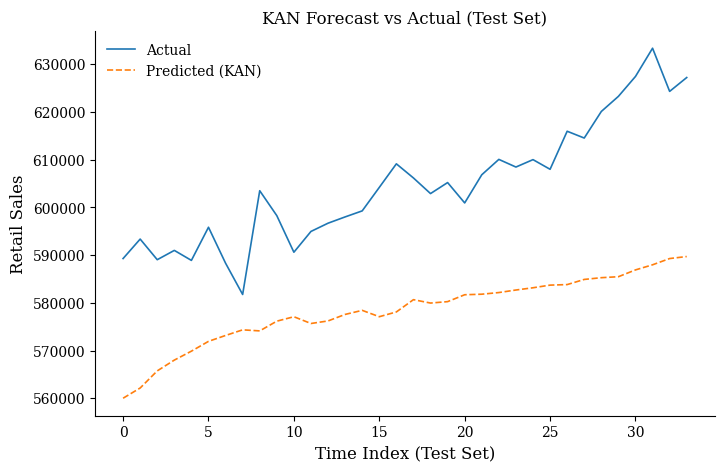

In [13]:
# Plot 1: Predicted vs Actual (Test Set)

minimalist_plot_setup()

plt.figure(figsize=(8, 5))
plt.plot(y_test_actual, label="Actual", linewidth=1.2)
plt.plot(predictions_kan, label="Predicted (KAN)", linestyle="--", linewidth=1.2)
plt.xlabel("Time Index (Test Set)")
plt.ylabel("Retail Sales")
plt.title("KAN Forecast vs Actual (Test Set)")
plt.legend(frameon=False)
plt.savefig("kan_vs_actual_testset.png", bbox_inches='tight')
plt.show()

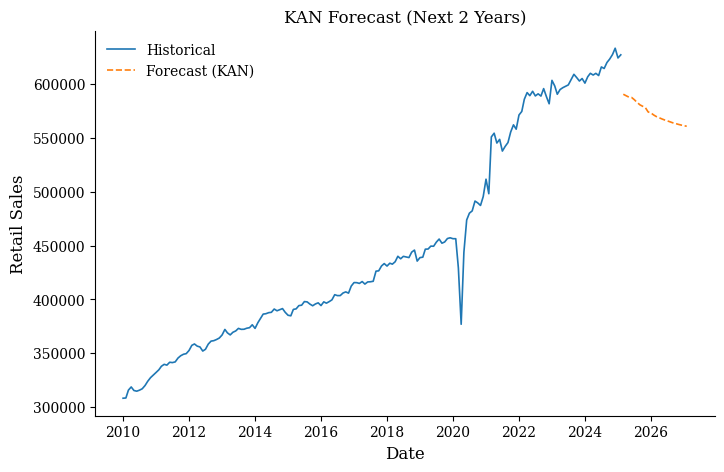

In [14]:
# Plot 2: Recursive Forecast (Next 24 Months)
steps_ahead = 24
last_known_scaled = scaled_values[-window_size:].flatten()
forecast_scaled = []

model.eval()
with torch.no_grad():
    for _ in range(steps_ahead):
        input_tensor = torch.tensor(last_known_scaled.reshape(1, -1), dtype=torch.float32)
        pred = model(input_tensor).item()
        forecast_scaled.append(pred)
        last_known_scaled = np.append(last_known_scaled[1:], pred)

forecast_unscaled = scaler.inverse_transform(np.array(forecast_scaled).reshape(-1, 1))

# Prepare future dates
last_date = df["date"].iloc[-1]
future_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=steps_ahead, freq='MS')

# Plot 2
minimalist_plot_setup()
plt.figure(figsize=(8, 5))
plt.plot(df["date"], df["value"], label="Historical", linewidth=1.2)
plt.plot(future_dates, forecast_unscaled, label="Forecast (KAN)", linestyle="--", linewidth=1.2)
plt.xlabel("Date")
plt.ylabel("Retail Sales")
plt.title("KAN Forecast (Next 2 Years)")
plt.legend(frameon=False)
plt.savefig("kan_forecast_future.png", bbox_inches='tight')
plt.show()